In [1]:
import os
import sys
import json
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [4]:
%matplotlib notebook

## One subject to begin

In [5]:
rec_folder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.


In [6]:
eeg_data, eeg_ts = exp.load_eegdata()
stim_log, good_chs = exp.qualitycheck_trials_chs()

In [7]:
sweep_states = {0: 'awake', 3: 'anesthetized'}

In [8]:
before_event = 1.0 # s, look at 100 ms pre-stim
after_event = 2.0 # s, look at 500 ms post-stim

apply_mask = True
apply_hpass = True

In [10]:
## Apply masking ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]
        
## Apply high-pass filter ##
start = time.time()
if apply_hpass:
    hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
    eeg_data = signal.filtfilt(hpb,hpa, eeg_data, axis=0)
end = time.time()
print('Highpass filter time: {:.2f} s'.format(end-start))

start = time.time()
z_traces = {}
st_type = 'biphasic'
# for st_type in stim_log.stim_type.unique():
    
z_traces[st_type] = {}

param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
for parami in param_list:

    z_traces[st_type][parami] = {}

    param_mask = (stim_log.stim_type == st_type) & (stim_log.parameter == parami)
    for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
        ## Get event times ##
        events = get_stim_events(stim_log, st_type, parami, sweepi)
        if len(events) == 0:
            print('{} {}, sweep {:d}: no good trials found'.format(st_type, str(parami), sweepi))
            continue
        print('{} {}, sweep {:d}: {:d} good trials'.format(st_type, str(parami), sweepi, events.shape[0]))
        GOOD_CHS = good_chs[st_type][parami][sweepi]
        ## Get event traces ##
        event_traces, event_ts = get_evoked_traces(
            eeg_data,
            eeg_ts,
            events,
            before_event,
            after_event,
            exp.ephys_params['EEG']['sample_rate']
        )
        comavg_ref = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
        comavg_event_traces = event_traces - comavg_ref[:,None,:]

        ## Design and apply lowpass Butterworth filter ##
        filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='lowpass')
        comavg_event_traces = signal.filtfilt(filtb, filta, comavg_event_traces, axis=0)
        
        ## Get z-score traces ## must trial average BEFORE doing z-score!
        comavg_event_traces = np.mean(comavg_event_traces, axis=2)
        baseline_mean = np.mean(comavg_event_traces[event_ts < -0.005, :], axis=0)
        baseline_std = np.std(comavg_event_traces[event_ts < -0.005, :], axis=0)

        ## Store traces ##
        z_traces[st_type][parami][sweepi] = [event_ts, (comavg_event_traces - baseline_mean) / baseline_std]
        
end = time.time()
print('Trace collection time: {:.2f} s'.format((end-start)))

Highpass filter time: 37.00 s
biphasic 10, sweep 0: 120 good trials
biphasic 10, sweep 1: 120 good trials
biphasic 10, sweep 2: 120 good trials
biphasic 10, sweep 3: 120 good trials
biphasic 30, sweep 0: 120 good trials
biphasic 30, sweep 1: 120 good trials
biphasic 30, sweep 2: 120 good trials
biphasic 30, sweep 3: 120 good trials
biphasic 50, sweep 0: 120 good trials
biphasic 50, sweep 1: 120 good trials
biphasic 50, sweep 2: 120 good trials
biphasic 50, sweep 3: 120 good trials
Trace collection time: 32.44 s


### Get durations

In [12]:
## Collect data for multi subjects ##
z_threshold = 5
comp_sweeps = [0,1,2,3]

ch_list = []
amp_list = []
sweep_list = []
dur_list = []
for ampi in z_traces['biphasic'].keys():
    for sweepi in comp_sweeps:
        timex = z_traces['biphasic'][ampi][sweepi][0]
        traces = z_traces['biphasic'][ampi][sweepi][1]
        for chi in good_chs['biphasic'][ampi][sweepi]:
            zinds = np.nonzero(np.abs(traces[:, chi]) > z_threshold)[0]
            if ((zinds.size > 0) and (timex[zinds[-1]] > 0)): 
                ch_list.append(chi)
                amp_list.append(ampi)
                sweep_list.append(sweepi)
                dur_list.append(timex[zinds[-1]])
                
duration_df = pd.DataFrame({
    'ch': ch_list,
    'amp': amp_list,
    'sweep': sweep_list,
    'duration': dur_list
})

<IPython.core.display.Javascript object>


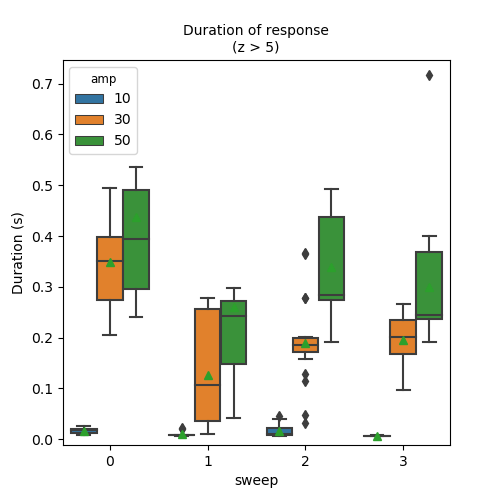

Text(0, 0.5, 'Duration (s)')

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
bxplt = sns.boxplot(x='sweep', y='duration', hue='amp', data=duration_df, showmeans=True)
bxplt.set_title('Duration of response\n(z > {:d})'.format(z_threshold))
bxplt.set_ylabel('Duration (s)')